# Imports

In [ ]:
# Install pip modules
!pip install yfinance
!pip install Flair
!pip install tensorflow==1.15
!pip install keras==2.1.6
!pip install stable-baselines
!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 10.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 412.3 MB 24 kB/s 
     |████████████████████████████████| 3.8 MB 51.3 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 50

In [ ]:
# Import required libraries
from google.colab import files
import string
import pandas as pd
import numpy as np
import requests
from textblob import TextBlob, Word
from sklearn.model_selection import train_test_split
from flair.models import TextClassifier
from flair.data import Sentence
from textblob.classifiers import NaiveBayesClassifier
import nltk
nltk.download(['punkt', 'stopwords', 'wordnet', 'brown'])
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C, ACKTR
from stable_baselines.common.policies import MlpPolicy
from env import StockTradingEnv

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


# 1. Sentiment Analysis

# 1.1. Data Preparation

In [ ]:
# Import a dataset from Kaggle
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ankurzing/sentiment-analysis-for-financial-news
!unzip sentiment-analysis-for-financial-news.zip

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes
  0% 0.00/903k [00:00<?, ?B/s]
100% 903k/903k [00:00<00:00, 51.4MB/s]
Archive:  sentiment-analysis-for-financial-news.zip
  inflating: FinancialPhraseBank/License.txt  
  inflating: FinancialPhraseBank/README.txt  
  inflating: FinancialPhraseBank/Sentences_50Agree.txt  
  inflating: FinancialPhraseBank/Sentences_66Agree.txt  
  inflating: FinancialPhraseBank/Sentences_75Agree.txt  
  inflating: FinancialPhraseBank/Sentences_AllAgree.txt  
  inflating: all-data.csv            


In [ ]:
# Collect additional data from stocknews api
data = {}
url = 'https://stocknewsapi.com/api/v1/category?section=general&items=50&token=zmxjsxt93zanhfibivlgb9ix8rpwv7su9qoxrtld&sentiment=neutral'
response = requests.get(url)
temp = response.json()
for i in temp['data']:
  title = i['title']
  sentiment = i['sentiment']
  data[title] = sentiment
data_pd = pd.DataFrame(data, index=[0]).T
data_pd.to_csv('sentiment_data.csv', mode='a', encoding='utf-8', index=True, header=False)

In [ ]:
# Read the kaggle dataset and stocknews dataset
news1 = pd.read_csv("all-data.csv", encoding="Windows-1252", names=["label", "sentence"])
news2 = pd.read_csv("sentiment_data.csv", names=["sentence", "label"])

# Join the two datasets
news3 = news1.append(news2)
news3.reset_index(drop=True, inplace=True)

In [ ]:
# Unify the labels by digitalising them
news3.loc[(news3.label == 'positive'),'label']=1
news3.loc[(news3.label == 'Positive'),'label']=1
news3.loc[(news3.label == 'Neutral'),'label']=0
news3.loc[(news3.label == 'neutral'),'label']=0
news3.loc[(news3.label == 'negative'),'label']=-1
news3.loc[(news3.label == 'Negative'),'label']=-1

In [ ]:
# Divide the dataset according to their labels
positives = []
neutrals = []
negatives = []
for index, row in news3.iterrows():
  if row['label'] == 1:
    positives.append((row['sentence'], row['label']))
  elif row['label'] == 0:
    neutrals.append((row['sentence'], row['label']))
  else:
    negatives.append((row['sentence'], row['label']))

# Leave only the same amount of data for balanced training
positives_cut = positives[:1979]
neutrals_cut = neutrals[:1979]
negatives_cut = negatives[:1979]

# Split the data into training and testing set
positive_train, positive_test = train_test_split(positives_cut, test_size=0.25)
neutral_train, neutral_test = train_test_split(neutrals_cut, test_size=0.25)
negative_train, negative_test = train_test_split(negatives_cut, test_size=0.25)

# Make numpy arrays to reshape the data
train = np.array([positive_train, neutral_train, negative_train]).reshape((-1, 2))
test = np.array([positive_test, neutral_test, negative_test]).reshape((-1, 2))

# Shuffle them
np.random.shuffle(train)
np.random.shuffle(test)

In [ ]:
# Create dataframes for pre-processing
train_pd = pd.DataFrame(train, columns=['sentence', 'label'])
test_pd = pd.DataFrame(test, columns=['sentence', 'label'])

In [ ]:
# Pre-process the training dataset
for index, row in train_pd.iterrows():
  sentence = row['sentence']
  # Tokenisation
  tokens = [word.lower() for word in TextBlob(sentence).words]
  # Stopword removal
  sentence_wo_sw = [word for word in tokens if not word in stopwords.words('english')]
  # Lemmatisation
  lemmatized_sentence = [Word(word).lemmatize() for word in sentence_wo_sw]
  # Concatenate the tokenised words into a sentence
  concatenated = ' '.join(lemmatized_sentence)
  # Replace the original data
  train_pd.loc[index, 'sentence'] = concatenated

In [ ]:
train_pd

,sentence,label
0,january 29 2009 largest nordic bank nordea fin...,0
1,sec freeze chinese company ipo disclosure report,-1
2,diluted earnings per share eps stood eur 0.25 ...,-1
3,effect saving noticeable beginning 2010,0
4,2009 incap expects revenue eur 70 million,0
...,...,...
4447,report profile 614 company including many key ...,0
4448,expects revenue 8.4 billion 8.7 billion compar...,0
4449,billionaire investor leon cooperman say stock ...,-1
4450,operator one 6 operator granted wimax license ...,0


In [ ]:
# Pre-process the testing datset
for index, row in test_pd.iterrows():
  sentence = row['sentence']
  tokens = [word.lower() for word in TextBlob(sentence).words]
  sentence_wo_sw = [word for word in tokens if not word in stopwords.words('english')]
  lemmatized_sentence = [Word(word).lemmatize() for word in sentence_wo_sw]
  concatenated = ' '.join(lemmatized_sentence)
  test_pd.loc[index, 'sentence'] = concatenated

In [ ]:
print(train_pd, test_pd)

                                               sentence  label
0     january 29 2009 largest nordic bank nordea fin...      0
1      sec freeze chinese company ipo disclosure report     -1
2     diluted earnings per share eps stood eur 0.25 ...     -1
3               effect saving noticeable beginning 2010      0
4             2009 incap expects revenue eur 70 million      0
...                                                 ...    ...
4447  report profile 614 company including many key ...      0
4448  expects revenue 8.4 billion 8.7 billion compar...      0
4449  billionaire investor leon cooperman say stock ...     -1
4450  operator one 6 operator granted wimax license ...      0
4451         25 august 2009 sampo 's stake nordea 19.45      0

[4452 rows x 2 columns]                                                sentence  label
0     combined foreign investment creates interestin...      1
1     engine electrical output 18,321 kw making larg...      0
2     however expects bank pro

In [ ]:
# Save as csv files for later runs
train_pd.to_csv('train_pd.csv', mode='w', index=False)
test_pd.to_csv('test_pd.csv', mode='w', index=False)

In [ ]:
# Load csv files
train_pd = pd.read_csv("train_pd.csv")
test_pd = pd.read_csv("test_pd.csv")

In [ ]:
# Create numpy arrays for training and testing of naive bayes classifier
train_np = train_pd.to_numpy().reshape((-1, 2))
test_np = train_pd.to_numpy().reshape((-1, 2))

# 1.2. Pretrained Models (TextBlob, Flair)

In [ ]:
# TextBlob (Rule-based approach)
tb_accuracy = 0 # Stores how many predictions are correct

# Iterate through all the rows in testing data
for index, row in test_pd.iterrows():
  # Create a class object of TextBlob
  sentence = TextBlob(row['sentence'])
  # Ground truth (supervised label)
  gt = int(row['label'])
  # The polarity score predicted by TextBlob's sentiment analysis model
  score = sentence.sentiment.polarity

  # Adjust the polarity score to match the original labels
  if score <= 1 and 0.4 <= score:
    score = 1 # => Positive
  elif score < 0.4 and -0.4 < score:
    score = 0 # => Neutral
  else:
    score = -1 # => Negative

  # If the prediction is the same as the ground truth, raise the accuracy by 1.
  if score == gt:
    tb_accuracy += 1

# Calculate the percentage of the accuracy
tb_accuracy = tb_accuracy/test_pd.shape[0] * 100
print(tb_accuracy)

37.10437710437711


In [ ]:
# Flair (Embedding-based approach)
# Load the sentiment classifier in Flair
fl_classifier = TextClassifier.load('en-sentiment')
fl_accuracy = 0
for index, row in test_pd.iterrows():
  sentence = Sentence(row['sentence'])
  gt = int(row['label'])
  fl_classifier.predict(sentence)
  score = sentence.labels[0].score # Polarity degree (float)
  value = sentence.labels[0].value # Polarity label (POSITIVE, NEGATIVE)
  
  # Make the value 0(neutral) if the polarity degree is low 
  if score <= 0.7:
    value = 0
  # Make 1 when positive
  elif value == 'POSITIVE':
    value = 1
  # Make -1 when negative
  else:
    value = -1
  if value == gt:
    fl_accuracy += 1

fl_accuracy = fl_accuracy/test_pd.shape[0] * 100
print(fl_accuracy)

2022-03-16 11:28:46,829 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt
49.562289562289564


# 1.3. Custom Models

# 1.3.1. Naive Bayes

In [ ]:
# Train the naive bayes classifier with the training data
nb_classifier = NaiveBayesClassifier(train_np)

In [ ]:
# Calculate the model accuracy
nb_accuracy = nb_classifier.accuracy(test_np) * 100

In [ ]:
# Show the predictions for each sentence in training data
nb_scores = []
for index, row in test_pd.iterrows():
  sentiment = nb_classifier.classify(row['sentence'])
  nb_scores.append(sentiment)

In [ ]:
# Show the most informative features for prediction
nb_classifier.show_informative_features(10)

Most Informative Features
     contains(inflation) = True               -1 : 0      =    133.0 : 1.0
     contains(increased) = True                1 : 0      =     36.3 : 1.0
          contains(rose) = True                1 : 0      =     28.2 : 1.0
          contains(fell) = True               -1 : 0      =     27.0 : 1.0
          contains(fall) = True               -1 : 0      =     26.3 : 1.0
     contains(decreased) = True               -1 : 0      =     22.6 : 1.0
        contains(design) = True                0 : -1     =     19.7 : 1.0
     contains(including) = True                0 : -1     =     19.0 : 1.0
          contains(open) = True               -1 : 0      =     19.0 : 1.0
        contains(higher) = True                1 : 0      =     18.6 : 1.0


In [ ]:
print(nb_accuracy)

86.74752920035938


# 1.4. Results

In [ ]:
# Create a dataframe to show all the results
result_pd = test_pd.copy(deep=True)
result_pd.rename({'label':'true label'}, axis=1)
result_pd['textblob'] = tb_scores
result_pd['flair'] = fl_scores
result_pd['naive bayes'] = nb_scores
print(result_pd)

In [ ]:
result_pd

,sentence,label,textblob,flair,naive bayes
0,combined foreign investment creates interestin...,1,0,1,1
1,"engine electrical output 18,321 kw making larg...",0,0,1,1
2,however expects bank provide alternative finan...,1,0,-1,1
3,investment place atrium plan expand moscow market,0,0,1,1
4,omx nordic 40 omxn40 index comprising 40 trade...,1,0,-1,-1
...,...,...,...,...,...
1480,el-erian delta variant n't going away,-1,0,-1,-1
1481,q1 2009 company 's result tax continuing opera...,-1,0,-1,-1
1482,current reference grade instrument challenging...,-1,0,-1,1
1483,gold 's breakout hope crashed focus shift u.s ...,-1,0,-1,-1


In [ ]:
# The function for plotting the accuracies on a bar chart
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        # Decide the location where the value for each bar is presented 
        location = height
        # If the value is negative, place the value right above the x-axis
        if height < 0:
          location = 0
        # Annotate the value for each bar
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, location),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

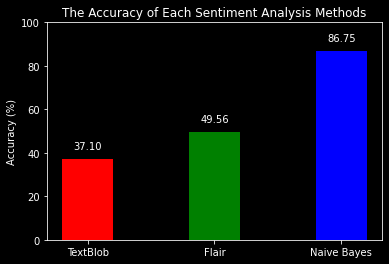

In [ ]:
# The dictionary for accuracy of each model
accuracies = {'TextBlob': tb_accuracy, 'Flair': fl_accuracy, 'Naive Bayes': nb_accuracy}

# Plot the accuracies
fig, ax = plt.subplots()
rects = ax.bar(list(accuracies.keys()), list(accuracies.values()), color=['r','g','b'], width=0.4)
x = np.arange(len(accuracies))  # the label locations
width = 0.4  # the width of the bars

ax.set_ylabel("Accuracy (%)")
ax.set_title("The Accuracy of Each Sentiment Analysis Methods")
ax.set_xticks(x)
ax.set_xticklabels(accuracies)
ax.set_ylim((0, 100))

autolabel(rects)

plt.show()

In [ ]:
# Collect data for simulation with the real market data
data = {}
url = 'https://stocknewsapi.com/api/v1?tickers=MSFT&items=50&token=zmxjsxt93zanhfibivlgb9ix8rpwv7su9qoxrtld&date=02142022-02182022'
response = requests.get(url)
temp = response.json()
for i in temp['data']:
  title = i['title']
  sentiment = i['sentiment']
  data[title] = sentiment
data_pd = pd.DataFrame(data, index=[0]).T
data_pd.to_csv('sentiment_data_MSFT_0214.csv', mode='w', encoding='utf-8', index=True, header=False)

In [ ]:
# Retrieve the trend data of MSFT on 4th Oct 2021
trends = yf.download('MSFT', start = '2021-10-04', end = '2021-10-05')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Append data for 4 weeks
trends = trends.append(yf.download('MSFT', start = '2021-10-25', end = '2021-10-26'))

[*********************100%***********************]  1 of 1 completed


In [ ]:
trends

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-04,287.399994,287.750000,280.250000,283.109985,282.009857,31350700
2021-10-11,292.920013,297.970001,292.750000,294.230011,293.086700,19298600
2021-10-18,303.570007,308.209991,302.690002,307.290009,306.095947,22729300
2021-10-25,309.359985,309.399994,306.459991,308.130005,306.932678,17554500


In [ ]:
# Save the data as a csv file
data_pd.to_csv('sentiment_data_MSFT_0124.csv', mode='w', encoding='utf-8', index=True, header=False)

In [ ]:
print(list(trends['Close']))

[283.1099853515625, 294.2300109863281, 307.2900085449219, 308.1300048828125]


Text(0.5, 1.0, "4 Weeks of MSFT Close and the Naive Bayes Classifier's Prediction")

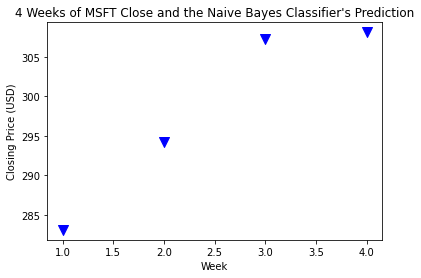

In [ ]:
# TextBlob simulation

# Load the collected datasets
datalist = ['sentiment_data_MSFT_0927.csv', 'sentiment_data_MSFT_1004.csv', 'sentiment_data_MSFT_1011.csv', 'sentiment_data_MSFT_1018.csv', ]
# Y axis indicates the closing price of MSFT for 4 weeks on every Monday
y_plot = [283.1099853515625, 294.2300109863281, 307.2900085449219, 308.1300048828125]
# X axis is the number of week
x_plot = [1, 2, 3, 4]

colors = [] # Stores the color of markers to mark with different colors depending on the prediction
markers = [] # Stores the shape of the markers

# Iterate through the datasets 
for data in datalist:
  test_news = pd.read_csv(data, names=["sentence", "label"])
  score = 0
  # For every row in the dataset
  for index, row in test_news.iterrows():
    # Pre-process the data
    sentence = row['sentence']
    tokens = TextBlob(sentence).words
    sentence_wo_sw = [word for word in tokens if not word in stopwords.words()]
    lemmatized_sentence = [Word(word).lemmatize() for word in sentence_wo_sw]
    concatenated = ' '.join(lemmatized_sentence)
    sentiment = int(nb_classifier.classify(concatenated)) # Stores the sentiment score of the classifier
    # Calculate the sum of all the scores
    score = score + sentiment

  # If the score is a positive number, the prediction towards the headlines is positive.
  if score >= 0: 
    # Mark with a red upward triangle
    colors.append('r')
    markers.append('^')
  # If it's a negative number, the prediction is negative.
  else:
    # Mark with a blue downward triangle
    colors.append('b')
    markers.append('v')

# Plot the results
fig, ax = plt.subplots()
for i in range(len(x_plot)):
  ax.scatter(x_plot[i], y_plot[i], c=colors[i], marker=markers[i], s=100)
ax.set_ylabel("Closing Price (USD)")
ax.set_xlabel("Week")
ax.set_title("4 Weeks of MSFT Close and the Naive Bayes Classifier's Prediction")

In [ ]:
# Naive Bayes classifier simulation

y_plot = [283.1099853515625, 294.2300109863281, 307.2900085449219, 308.1300048828125]
x_plot = [1, 2, 3, 4]
colors = []
markers = []
for data in datalist:
  test_news = pd.read_csv(data, names=["sentence", "label"])
  score = 0
  for index, row in test_news.iterrows():
    sentence = row['sentence']
    tokens = TextBlob(sentence).words
    sentence_wo_sw = [word for word in tokens if not word in stopwords.words()]
    lemmatized_sentence = [Word(word).lemmatize() for word in sentence_wo_sw]
    concatenated = ' '.join(lemmatized_sentence)
    sentiment = int(nb_classifier.classify(concatenated))
    score = score + sentiment
  if score >= 0:
    colors.append('r')
    markers.append('^')
  else:
    colors.append('b')
    markers.append('v')

fig, ax = plt.subplots()
for i in range(len(x_plot)):
  ax.scatter(x_plot[i], y_plot[i], c=colors[i], marker=markers[i], s=100)
ax.set_ylabel("Closing Price (USD)")
ax.set_xlabel("Week")
ax.set_title("4 Weeks of MSFT Close and the Naive Bayes Classifier's Prediction")

Text(0.5, 1.0, "4 Weeks of MSFT Close and Flair's Prediction")

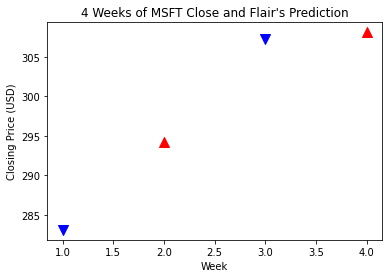

In [ ]:
# Flair simulation

y_plot = [283.1099853515625, 294.2300109863281, 307.2900085449219, 308.1300048828125]
x_plot = [1, 2, 3, 4]
colors = []
markers = []
for data in datalist:
  test_news = pd.read_csv(data, names=["sentence", "label"])
  score = 0
  for index, row in test_news.iterrows():
    sentence = row['sentence']
    tokens = TextBlob(sentence).words
    sentence_wo_sw = [word for word in tokens if not word in stopwords.words()]
    lemmatized_sentence = [Word(word).lemmatize() for word in sentence_wo_sw]
    concatenated = ' '.join(lemmatized_sentence)
    sentence = Sentence(concatenated)
    fl_classifier.predict(sentence)
    value = sentence.labels[0].value
    # Do not make 'neutral' labels here to reduce ambiguity
    if value == 'POSITIVE':
      score += 1
    elif value == 'NEGATIVE':
      score -= 1
  if score >= 0:
    colors.append('r')
    markers.append('^')
  else:
    colors.append('b')
    markers.append('v')

fig, ax = plt.subplots()
for i in range(len(x_plot)):
  ax.scatter(x_plot[i], y_plot[i], c=colors[i], marker=markers[i], s=100)
ax.set_ylabel("Closing Price (USD)")
ax.set_xlabel("Week")
ax.set_title("4 Weeks of MSFT Close and Flair's Prediction")

# Reinforcement Learning

In [ ]:
# Read the tickers of the target companies
with open('constituents_symbols.txt') as f:
    stocks = f.read().splitlines()

In [ ]:
# The function to train and test the 

# algorithm=['A2C', 'ACKTR'], gamma=discount_factor, period=test_data_period, interval=test_data_interval
def result(stocks, algorithm, gamma, timesteps, period, interval):

  result = {}
  # For all the stock tickers in stocks
  for stock in stocks:
    # Load training data
    data_train = yf.download(stock, start = '2011-01-01', end = '2021-01-01')
    # Load testing data (period=[1 year, 6 month, 1 month])
    data_test = yf.download(stock, period=period)
    # Replace the data column with an index column  
    data_train['Date'] = data_train.index
    data_test['Date'] = data_test.index
    data_train.index = np.arange(0, len(data_train))
    data_test.index = np.arange(0, len(data_test))
    
    # Import the gym environment with the training data
    env = DummyVecEnv([lambda: StockTradingEnv(data_train)])

    # If the algorithm given is A2C
    if algorithm == 'A2C':
      # Create an A2C model using stable baselines library
      model = A2C(MlpPolicy, env, gamma=gamma, verbose=1)
      # Train
      model.learn(total_timesteps=timesteps)

    # If the algorith is other than A2C (=ACKTR)
    else:
      # Create an ACKTR model
      model = ACKTR(MlpPolicy, env, gamma=gamma, verbose=1)
      model.learn(total_timesteps=timesteps)

    model_profits = [] # Stores all the profits made in each episode
    # Runs three episodes
    for _ in range(3):
      # Create a new environment with the testing data
      env_test = StockTradingEnv(data_test)
      env_test.reset()
      # Input the new environment to the environment that the model is using
      env.envs[0] = env_test
      # Reset the observation space
      obs = env.reset()

      # For all the rows in the testing data
      for i in range(len(data_test)):
        # Calculate the action and the next state with the observation info
        action, _states = model.predict(obs)
        # Move onto the next timestep with the action resulted
        obs, rewards, done, info = env.step(action)
        # Show the testing process
        env.render(mode='no')
      # Append the final profit made in the episode
      model_profits.append(env.envs[0].profit)

    # Calculate the mean of the profits for each stock
    result[stock] = np.mean(model_profits)

  return result

In [ ]:
algos = ['A2C', 'ACKTR']
# gamma => discount factor
gamma = 0.99
# timestep => How many timesteps the agent will take in overall
timesteps = 20000
# 1 day corresponds to 1 timestep
interval = '1d'

final_6mo_99 = {} # Stores the results of 6 month simulation with 0.99 of discount rate
final_1y_99 = {} # Stores the results of 1 year simulation with 0.99 of discount rate
final_1mo_99 = {} # Stores the results of 1 month simulation with 0.99 of discount rate

# Run for all the algorithms
for algo in algos:
  final_6mo_99[algo] = result(stocks, algo, gamma, timesteps, '6mo', interval)
for algo in algos:
  final_1mo_99[algo] = result(stocks, algo, gamma, timesteps, '1mo', interval)
for algo in algos:
  final_1y_99[algo] = result(stocks, algo, gamma, timesteps, '1y', interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------
| explained_variance | 3.28e-05 |
| fps                | 10       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 130      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 206      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 238       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| total_timesteps    | 1000      |
| value_loss         | 1.06e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 251      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1500     |
| value_loss         | 2.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 258      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timesteps    | 2000     |
| value_loss         | 4.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 260      |
| nupdates           | 500      |
| policy_entropy     | 2.8      |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 3.12e-05 |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 284      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 245       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.65e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 264      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 269      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 271      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000451 |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 205      |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 246      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 260      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 267      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 3.66e+07 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 269       |
| nupdates           | 400       |
| policy_entropy     | 2.8       |
| total_timesteps    | 2000      |
| value_loss         | 4.83e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 272      |
| nupdates           | 500      |
| policy_entropy     | 2.78     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -0.000314 |
| fps                | 10        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 139       |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 219      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 245      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
----------------------------------
| e

/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 260      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timesteps    | 2000     |
| value_loss         | 4.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 264      |
| nupdates           | 500      |
| policy_entropy     | 2.8      |
| total_timesteps    | 2500     |
| value_loss         | 1.15e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 266       |
| nupdates           | 600       |
| policy_entropy     | 2.78      |
| total_timesteps    | 3000      |
| value_loss         | 7.34e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 700      |
| policy_entropy     | 2.78     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000396 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 224      |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.69e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 267       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 1.11e+07  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 267       |
| nupdates           | 300       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1500      |
| value_loss         | 2.4e+07   |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 270       |
| nupdates           | 400       |
| policy_entropy     | 2.81      |
| total_timesteps    | 2000      |
| value_loss         | 4.27e+07  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 273       |
| nupdates           | 500       |
| policy_entropy     | 2.79      |
| total_timesteps    | 2500      |
| value_loss         | 1.61e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 274       |
| nupdates           | 600       |
| policy_entropy    

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00136  |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 194      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 256       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.72e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 268      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 275      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 277      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 278      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 256       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.65e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 268      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 273      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 276      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 3.34e-06 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 130      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 246      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 260      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 1.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 266      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000471 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 130      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 254       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 2.65e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 267      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 272      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.42e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 274      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 2.53e-05 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 170      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 258      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 271      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 2.96e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 274       |
| nupdates           | 400       |
| policy_entropy     | 2.79      |
| total_timesteps    | 2000      |
| value_loss         | 4.29e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 274      |
| nupdates           | 500      |
| policy_entropy     | 2.78     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0972   |
| total_timesteps    | 20        |
| value_loss         | 2.16e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 240       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0986    |
| total_timesteps    | 2000      |
| value_loss         | 4.96e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 256      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0103   |
| total_timesteps    | 4000     |
| value_loss         | 2.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-0

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.181    |
| total_timesteps    | 20       |
| value_loss         | 2.11e+04 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 248       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0744    |
| total_timesteps    | 2000      |
| value_loss         | 4.95e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 260      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0437  |
| total_timesteps    | 4000     |
| value_loss         | 2.72e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 265       |
| nupdates           | 300       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.301    |
| total_timesteps    | 6000      |
| value_loss         | 1.15e+08  |
----------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.12    |
| total_timesteps    | 20       |
| value_loss         | 2.07e+04 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 243      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0776   |
| total_timesteps    | 2000     |
| value_loss         | 1.56e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 257      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0992  |
| total_timesteps    | 4000     |
| value_loss         | 2.83e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 262      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.00905  |
| total_timesteps    | 6000     |
| value_loss         | 1.15e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps       

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 20        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.126    |
| total_timesteps    | 20        |
| value_loss         | 2.14e+04  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 245       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.146     |
| total_timesteps    | 2000      |
| value_loss         | 4.95e+08  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 257       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0316    |
| total_timesteps    | 4000      |
| value_loss         | 4.15e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 262      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0484   |
| total_timesteps    | 6000     |
| value_loss         | 3.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 266      |
| nupdates           | 400      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0541   |
| total_timesteps    | 8000     |
| value_loss         | 3.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 5.64e-05 |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0662  |
| total_timesteps    | 20       |
| value_loss         | 2.18e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 246      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.112   |
| total_timesteps    | 2000     |
| value_loss         | 7.73e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 257      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.00894  |
| total_timesteps    | 4000     |
| value_loss         | 2.73e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps       

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 2.58e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.186    |
| total_timesteps    | 20       |
| value_loss         | 2.08e+04 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 251       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.407     |
| total_timesteps    | 2000      |
| value_loss         | 4.97e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.216   |
| total_timesteps    | 4000     |
| value_loss         | 3.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 270      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.128   |
| total_timesteps    | 6000     |
| value_loss         | 1.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.19    |
| total_timesteps    | 20       |
| value_loss         | 2.06e+04 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 246      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.102   |
| total_timesteps    | 2000     |
| value_loss         | 4.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 255      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0314  |
| total_timesteps    | 4000     |
| value_loss         | 2.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 260      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.165   |
| total_timesteps    | 6000     |
| value_loss         | 1.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps         

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.174   |
| total_timesteps    | 20       |
| value_loss         | 2.07e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 250      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.137    |
| total_timesteps    | 2000     |
| value_loss         | 4.96e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 263       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0671    |
| total_timesteps    | 4000      |
| value_loss         | 2.71e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 3.46e-06 |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.378   |
| total_timesteps    | 20       |
| value_loss         | 2.07e+04 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 243      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.00705  |
| total_timesteps    | 2000     |
| value_loss         | 6.54e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 259       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.383    |
| total_timesteps    | 4000      |
| value_loss         | 2.73e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 249      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0733   |
| total_timesteps    | 6000     |
| value_loss         | 1.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0329   |
| total_timesteps    | 20        |
| value_loss         | 2.07e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 256      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.332   |
| total_timesteps    | 2000     |
| value_loss         | 5.29e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.511   |
| total_timesteps    | 4000     |
| value_loss         | 2.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 5.49e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 260      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 241       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.65e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 258       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 1.07e+07  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 263      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 2.39e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 267       |
| nupdates           | 400       |
| policy_entropy     | 2.81      |
| total_timesteps    | 2000      |
| value_loss         | 4.27e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 270       |
| nupdates           | 500       |
| policy_entropy     | 2.8       |
| total_timesteps    | 2500      |
| value_loss         | 6.73e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 272      |
| nupdates           | 600      |
| policy_entropy     | 2.79     

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.15e-05 |
| fps                | 9         |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 138       |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 153       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 2.65e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 158      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 300      |
| policy_entropy     | 2.82     

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -3.67e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 292       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 248      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.68e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 246      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.08e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 258       |
| nupdates           | 300       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1500      |
| value_loss         | 2.44e+07  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 264       |
| nupdates           | 400       |
| policy_entropy     | 2.83      |
|

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -0.000201 |
| fps                | 20        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 130       |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 250       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.65e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 263      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.06e+07 |
---------------------------------
------------------------------

/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 271       |
| nupdates           | 400       |
| policy_entropy     | 2.8       |
| total_timesteps    | 2000      |
| value_loss         | 1.18e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 273      |
| nupdates           | 500      |
| policy_entropy     | 2.8      |
| total_timesteps    | 2500     |
| value_loss         | 2e+06    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 275      |
| nupdates           | 600      |
| policy_entropy     | 2.8      |
| total_timesteps    | 3000     |
| value_loss         | 7.34e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 276      |
| nupdates           | 700      |
| policy_entropy     | 2.77     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | -0.00108 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 162      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 254      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.72e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 269       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 1.09e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 271      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 2.51e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 274       |
| nupdates           | 400       |
| policy_entropy     | 2.8       |
|

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00035  |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 133      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 262       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 2.71e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 273      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 278      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 281      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -1.36e-05 |
| fps                | 23        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 262       |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 254       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.65e+06  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 266      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 271      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.4e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 273       |
| nupdates           | 400       |
| policy_entropy     | 2.79      |
| total_timesteps    | 2000      |
| value_loss         | 4.27e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 274      |
| nupdates           | 500      |
| policy_entropy     | 2.77     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -1.92e-05 |
| fps                | 19        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 168       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 249      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 3.14e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 257      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 265      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 2.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 269      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -1.49e-05 |
| fps                | 22        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 206       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 253      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 274       |
| nupdates           | 300       |
| policy_entropy     | 2.81      |
| total_timesteps    | 1500      |
| value_loss         | 2.43e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 276      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -0.000118 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 131       |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 270      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1500     |
| value_loss         | 2.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 274      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timesteps    | 2000     |
| value_loss         | 4.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 275      |
| nupdates           | 500      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.191     |
| total_timesteps    | 20        |
| value_loss         | 2.07e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.262    |
| total_timesteps    | 2000     |
| value_loss         | 8.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.356   |
| total_timesteps    | 4000     |
| value_loss         | 2.71e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 22        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0852    |
| total_timesteps    | 20        |
| value_loss         | 2.07e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 252       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0653    |
| total_timesteps    | 2000      |
| value_loss         | 4.95e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0721  |
| total_timesteps    | 4000     |
| value_loss         | 2.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -1.25e-05 |
| fps                | 22        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0166   |
| total_timesteps    | 20        |
| value_loss         | 2.09e+04  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 257       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.23      |
| total_timesteps    | 2000      |
| value_loss         | 5.26e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 270      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.235   |
| total_timesteps    | 4000     |
| value_loss         | 2.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 275      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.408    |
| total_timesteps    | 6000     |
| value_loss         | 1.15e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.177   |
| total_timesteps    | 20       |
| value_loss         | 2.35e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 254       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0932    |
| total_timesteps    | 2000      |
| value_loss         | 1.33e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 263       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0919   |
| total_timesteps    | 4000      |
| value_loss         | 4.2e+08   |
----------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 3.41e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.038   |
| total_timesteps    | 20       |
| value_loss         | 2.13e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 257       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0172    |
| total_timesteps    | 2000      |
| value_loss         | 5.35e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 254      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0507  |
| total_timesteps    | 4000     |
| value_loss         | 3.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -3.06e-05 |
| fps                | 20        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.495    |
| total_timesteps    | 20        |
| value_loss         | 2.09e+04  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 175       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| policy_loss        | 0.11      |
| total_timesteps    | 2000      |
| value_loss         | 5.32e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 215      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| policy_loss        | 0.112    |
| total_timesteps    | 4000     |
| value_loss         | 2.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 234      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| policy_loss        | 0.331    |
| total_timesteps    | 6000     |
| value_loss         | 1.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.11    |
| total_timesteps    | 20       |
| value_loss         | 2.33e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 251       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0431   |
| total_timesteps    | 2000      |
| value_loss         | 4.95e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.472   |
| total_timesteps    | 4000     |
| value_loss         | 2.72e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 22        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.369    |
| total_timesteps    | 20        |
| value_loss         | 2.07e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 250      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| policy_loss        | -0.0508  |
| total_timesteps    | 2000     |
| value_loss         | 4.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| policy_loss        | -0.61    |
| total_timesteps    | 4000     |
| value_loss         | 2.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 22        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.209     |
| total_timesteps    | 20        |
| value_loss         | 2.07e+04  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 250      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.146    |
| total_timesteps    | 2000     |
| value_loss         | 5.99e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0709  |
| total_timesteps    | 4000     |
| value_loss         | 2.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 270      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.219    |
| total_timesteps    | 6000     |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps         

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.157    |
| total_timesteps    | 20        |
| value_loss         | 2.48e+04  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.208   |
| total_timesteps    | 2000     |
| value_loss         | 7.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 263      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0269   |
| total_timesteps    | 4000     |
| value_loss         | 2.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 270      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.704   |
| total_timesteps    | 6000     |
| value_loss         | 1.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps         

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -6.02e-05 |
| fps                | 22        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 133       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 254       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.88e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 271      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 277      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 2.4e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 280       |
| nupdates           | 400       |
| policy_entropy     | 2.8       |
|

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -4.14e-05 |
| fps                | 20        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 131       |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 248      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 3.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 262      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.06e+07 |
---------------------------------
---------------------------------
| ex

/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 270      |
| nupdates           | 400      |
| policy_entropy     | 2.79     |
| total_timesteps    | 2000     |
| value_loss         | 4.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 272      |
| nupdates           | 500      |
| policy_entropy     | 2.79     |
| total_timesteps    | 2500     |
| value_loss         | 6.76e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 273       |
| nupdates           | 600       |
| policy_entropy     | 2.77      |
| total_timesteps    | 3000      |
| value_loss         | 2.48e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 274      |
| nupdates           | 700      |
| policy_entropy     | 2.75     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -5.02e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 244       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 249      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.69e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 267       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 1.09e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 273      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1500     |
| value_loss         | 2.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 276      |
| nupdates           | 400      |
| policy_entropy     | 2.82     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000175 |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 132      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 255      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.66e+06 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 269      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 275      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.42e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 278      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timesteps    | 2000     |
| value_loss         | 4.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 279      |
| nupdates           | 500      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | -0.0008  |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 173      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 199       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 2.66e+06  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 164      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 154      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1500     |
| value_loss         | 2.55e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 153       |
| nupdates           | 400       |
| policy_entropy     | 2.83      |
|

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00244  |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 173      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 251       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.69e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 269      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 275      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 5.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 279      |
| nupdates           | 400      |
| policy_entropy     | 2.82     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 23        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 268       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 269      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 274      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 2.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 277      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 9.42e-06 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 174      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 254      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 269      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.06e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 274       |
| nupdates           | 300       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1500      |
| value_loss         | 2.4e+07   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 275      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 13       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 219      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 167      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.66e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 189       |
| nupdates           | 200       |
| policy_entropy     | 2.81      |
| total_timesteps    | 1000      |
| value_loss         | 1.07e+07  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 197       |
| nupdates           | 300       |
| policy_entropy     | 2.8       |
|

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 218      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 249      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 270      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.4e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 272       |
| nupdates           | 400       |
| policy_entropy     | 2.81      |
| total_t

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.064     |
| total_timesteps    | 20        |
| value_loss         | 2.97e+04  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 252       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.326     |
| total_timesteps    | 2000      |
| value_loss         | 1.64e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 265       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.112     |
| total_timesteps    | 4000      |
| value_loss         | 2.71e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 270      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.243   |
| total_timesteps    | 6000     |
| value_loss         | 1.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-0

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0198   |
| total_timesteps    | 20       |
| value_loss         | 2.06e+04 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.16    |
| total_timesteps    | 2000     |
| value_loss         | 4.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 263      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0413  |
| total_timesteps    | 4000     |
| value_loss         | 7.37e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 268       |
| nupdates           | 300       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0933    |
| total_timesteps    | 6000      |
| value_loss         | 1.15e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 4.63e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.254    |
| total_timesteps    | 20       |
| value_loss         | 2.1e+04  |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 253       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.155    |
| total_timesteps    | 2000      |
| value_loss         | 6.8e+08   |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 264      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0332   |
| total_timesteps    | 4000     |
| value_loss         | 4.22e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0912   |
| total_timesteps    | 20       |
| value_loss         | 2.51e+04 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 254       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.275     |
| total_timesteps    | 2000      |
| value_loss         | 4.98e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 266      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.348    |
| total_timesteps    | 4000     |
| value_loss         | 4.74e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 271       |
| nupdates           | 300       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.389    |
| total_timesteps    | 6000      |
| value_loss         | 3.41e+08  |
----------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -6.08e-06 |
| fps                | 20        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0634   |
| total_timesteps    | 20        |
| value_loss         | 2.12e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 246       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0393   |
| total_timesteps    | 2000      |
| value_loss         | 5.07e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 259      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.178    |
| total_timesteps    | 4000     |
| value_loss         | 2.87e+08 |
---------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 9.44e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.138    |
| total_timesteps    | 20       |
| value_loss         | 2.07e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 252       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.108     |
| total_timesteps    | 2000      |
| value_loss         | 5.13e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 264      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.146    |
| total_timesteps    | 4000     |
| value_loss         | 2.79e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0922   |
| total_timesteps    | 20       |
| value_loss         | 2.06e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 256       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 2.59e-05  |
| total_timesteps    | 2000      |
| value_loss         | 4.95e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0258  |
| total_timesteps    | 4000     |
| value_loss         | 2.71e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0        |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.203   |
| total_timesteps    | 20       |
| value_loss         | 2.07e+04 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.388    |
| total_timesteps    | 2000     |
| value_loss         | 4.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 262      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.225   |
| total_timesteps    | 4000     |
| value_loss         | 2.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 266      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0244  |
| total_timesteps    | 6000     |
| value_loss         | 1.14e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps       

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 20        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.151    |
| total_timesteps    | 20        |
| value_loss         | 2.14e+04  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 253      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.141   |
| total_timesteps    | 2000     |
| value_loss         | 4.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 267      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.253   |
| total_timesteps    | 4000     |
| value_loss         | 3.8e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 271      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0177   |
| total_timesteps    | 6000     |
| value_loss         | 1.85e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps         

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0916   |
| total_timesteps    | 20       |
| value_loss         | 2.07e+04 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 246      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.209    |
| total_timesteps    | 2000     |
| value_loss         | 5.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 260      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.258   |
| total_timesteps    | 4000     |
| value_loss         | 2.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 264      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0942   |
| total_timesteps    | 6000     |
| value_loss         | 1.15e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps       

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
gamma = 0.5
final_6mo_05 = {}
final_1y_05 = {}
final_1mo_05 = {}
for algo in algos:
  final_6mo_05[algo] = result(stocks, algo, gamma, timesteps, '6mo', interval)
for algo in algos:
  final_1mo_05[algo] = result(stocks, algo, gamma, timesteps, '1mo', interval)
for algo in algos:
  final_1y_05[algo] = result(stocks, algo, gamma, timesteps, '1y', interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


----------------------------------
| explained_variance | -1.57e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 37.6      |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 248      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 6.75e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 224      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 189      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 6.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 177      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000169 |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 35.2     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 199      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 7.41e+05 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 221      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 239      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 6.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 249      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timesteps    | 2000     |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 255      |
| nupdates           | 500      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00289  |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 30.2     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 250       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 6.86e+05  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 266      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 2.77e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 271       |
| nupdates           | 300       |
| policy_entropy     | 2.81      |
| total_timesteps    | 1500      |
| value_loss         | 6.13e+06  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 274       |
| nupdates           | 400       |
| policy_entropy     | 2.79 

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000473 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 39.3     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 6.75e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 268      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 272      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 6.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 275      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | -0.0074  |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 30.7     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 252      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 6.78e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 267      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 272       |
| nupdates           | 300       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1500      |
| value_loss         | 6.1e+06   |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 276       |
| nupdates           | 400       |
| policy_entropy     | 2.81      |
|

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00154  |
| fps                | 24       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 51.8     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 253       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 6.87e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 269      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.84e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 273      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 6.38e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 276       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
|

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 2.59e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 32.9     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 257       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 6.74e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 270      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 274      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 6.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 277      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -4.52e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 32.9      |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 250      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 6.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 272      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 6.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 275      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000464 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 53.6     |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 254      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 6.74e+05 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 270       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 2.74e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 275      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 6.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 278      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timesteps    | 2000     |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 279      |
| nupdates           | 500      |
| policy_entropy     | 2.79     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -0.000113 |
| fps                | 23        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 29.9      |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 255      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 6.75e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 271       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 2.72e+06  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 275       |
| nupdates           | 300       |
| policy_entropy     | 2.81      |
| total_timesteps    | 1500      |
| value_loss         | 6.11e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 277       |
| nupdates           | 400       |
| policy_entropy     | 2.81 

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0389   |
| total_timesteps    | 20        |
| value_loss         | 523       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 249      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.401   |
| total_timesteps    | 2000     |
| value_loss         | 1.43e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 262       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.124    |
| total_timesteps    | 4000      |
| value_loss         | 7.74e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 267      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.00353 |
| total_timesteps    | 6000     |
| value_loss         | 3.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.09e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0824   |
| total_timesteps    | 20        |
| value_loss         | 522       |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 252       |
| nupdates           | 100       |
| policy_entropy     | 2.85      |
| policy_loss        | -1.08     |
| total_timesteps    | 2000      |
| value_loss         | 1.43e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 263       |
| nupdates           | 200       |
| policy_entropy     | 2.85      |
| policy_loss        | -0.186    |
| total_timesteps    | 4000      |
| value_loss         | 7.76e+06  |
----------------------------------
----------------------------------
| explained_variance

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0.000205 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.401    |
| total_timesteps    | 20       |
| value_loss         | 972      |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 253       |
| nupdates           | 100       |
| policy_entropy     | 2.87      |
| policy_loss        | 0.0843    |
| total_timesteps    | 2000      |
| value_loss         | 3.08e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 266      |
| nupdates           | 200      |
| policy_entropy     | 2.87     |
| policy_loss        | -0.255   |
| total_timesteps    | 4000     |
| value_loss         | 8.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 3.93e-06 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.00576 |
| total_timesteps    | 20       |
| value_loss         | 536      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 252       |
| nupdates           | 100       |
| policy_entropy     | 2.86      |
| policy_loss        | -0.0208   |
| total_timesteps    | 2000      |
| value_loss         | 4.02e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 264       |
| nupdates           | 200       |
| policy_entropy     | 2.86      |
| policy_loss        | 0.386     |
| total_timesteps    | 4000      |
| value_loss         | 2.45e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 300      |
| policy_entropy     | 2.87     |
| policy_loss        | 0.0763   |
| total_timesteps    | 6000     |
| value_loss         | 9.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | -2.5e-05 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.235    |
| total_timesteps    | 20       |
| value_loss         | 621      |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 251       |
| nupdates           | 100       |
| policy_entropy     | 2.86      |
| policy_loss        | -0.455    |
| total_timesteps    | 2000      |
| value_loss         | 1.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 263      |
| nupdates           | 200      |
| policy_entropy     | 2.86     |
| policy_loss        | 0.168    |
| total_timesteps    | 4000     |
| value_loss         | 7.73e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0.000465 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.324   |
| total_timesteps    | 20       |
| value_loss         | 614      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 250       |
| nupdates           | 100       |
| policy_entropy     | 2.8       |
| policy_loss        | 0.574     |
| total_timesteps    | 2000      |
| value_loss         | 1.52e+07  |
----------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 263      |
| nupdates           | 200      |
| policy_entropy     | 2.8      |
| policy_loss        | 0.0535   |
| total_timesteps    | 4000     |
| value_loss         | 9.1e+06  |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 20        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.271     |
| total_timesteps    | 20        |
| value_loss         | 801       |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 252       |
| nupdates           | 100       |
| policy_entropy     | 2.86      |
| policy_loss        | -0.048    |
| total_timesteps    | 2000      |
| value_loss         | 1.43e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 266      |
| nupdates           | 200      |
| policy_entropy     | 2.86     |
| policy_loss        | -0.0215  |
| total_timesteps    | 4000     |
| value_loss         | 7.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-0

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.159    |
| total_timesteps    | 20       |
| value_loss         | 576      |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 248      |
| nupdates           | 100      |
| policy_entropy     | 2.87     |
| policy_loss        | 0.154    |
| total_timesteps    | 2000     |
| value_loss         | 1.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 260      |
| nupdates           | 200      |
| policy_entropy     | 2.88     |
| policy_loss        | 0.0568   |
| total_timesteps    | 4000     |
| value_loss         | 7.74e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps         

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -8.51e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.31      |
| total_timesteps    | 20        |
| value_loss         | 520       |
----------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 245      |
| nupdates           | 100      |
| policy_entropy     | 2.86     |
| policy_loss        | -0.129   |
| total_timesteps    | 2000     |
| value_loss         | 1.44e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 258       |
| nupdates           | 200       |
| policy_entropy     | 2.86      |
| policy_loss        | -0.178    |
| total_timesteps    | 4000      |
| value_loss         | 7.76e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 3.05e-05 |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.29     |
| total_timesteps    | 20       |
| value_loss         | 580      |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 245      |
| nupdates           | 100      |
| policy_entropy     | 2.87     |
| policy_loss        | 0.0295   |
| total_timesteps    | 2000     |
| value_loss         | 1.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 259      |
| nupdates           | 200      |
| policy_entropy     | 2.87     |
| policy_loss        | -0.0123  |
| total_timesteps    | 4000     |
| value_loss         | 7.75e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps       

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 6.74e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 49.9     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 255      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 6.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 266      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 273      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 1.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 275      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -4.05e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 47.9      |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 256      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 6.75e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 271       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| total_timesteps    | 1000      |
| value_loss         | 2.71e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 276      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 6.15e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 277      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00184  |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 54       |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 254       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 6.77e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 271      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 2.79e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 275       |
| nupdates           | 300       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1500      |
| value_loss         | 6.37e+06  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 279       |
| nupdates           | 400       |
| policy_entropy     | 2.81 

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000204 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 55.2     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 6.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 3.08e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 270       |
| nupdates           | 300       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1500      |
| value_loss         | 6.19e+06  |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 274      |
| nupdates           | 400      |
| policy_entropy     | 2.82     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000767 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 29.9     |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 256      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 9.28e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 271       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 2.74e+06  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 276      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 1.39e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 280       |
| nupdates           | 400       |
| policy_entropy     | 2.81      |
| total_timesteps    | 2000      |
| value_loss         | 1.13e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 280       |
| nupdates           | 500       |
| policy_entropy     | 2.81      |
| total_timesteps    | 2500      |
| value_loss         | 1.83e+07  |
----------------------------------
----------------------------------
| explained_variance | -8.23e-06 |
| fps                | 280       |
| nupdates           | 600       |
| policy_entropy     | 2.78 

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00421  |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 31.5     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 261      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 6.75e+05 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 274       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 2.77e+06  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 276       |
| nupdates           | 300       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1500      |
| value_loss         | 6.35e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 278       |
| nupdates           | 400       |
| policy_entropy     | 2.81 

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -3.72e-05 |
| fps                | 24        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 31        |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 254       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 6.74e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
------------------------------

/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 275       |
| nupdates           | 500       |
| policy_entropy     | 2.81      |
| total_timesteps    | 2500      |
| value_loss         | 1.75e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 276      |
| nupdates           | 600      |
| policy_entropy     | 2.8      |
| total_timesteps    | 3000     |
| value_loss         | 6.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 277      |
| nupdates           | 700      |
| policy_entropy     | 2.81     |
| total_timesteps    | 3500     |
| value_loss         | 2.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 278      |
| nupdates           | 800      |
| policy_entropy     | 2.8      |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 6.19e-05 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 29.8     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 254      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 6.74e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 268       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 2.71e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 271       |
| nupdates           | 300       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1500      |
| value_loss         | 6.1e+06   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 275      |
| nupdates           | 400      |
| policy_entropy     | 2.82     

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00101  |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 42.8     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 253      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 6.78e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 267       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 2.71e+06  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 271       |
| nupdates           | 300       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1500      |
| value_loss         | 6.16e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 274      |
| nupdates           | 400      |
| policy_entropy     | 2.81     

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000229 |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 29.9     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 255      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 6.75e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 270       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 2.71e+06  |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 275      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 6.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 278      |
| nupdates           | 400      |
| policy_entropy     | 2.82     |
| total_timesteps    | 2000     |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 280      |
| nupdates           | 500      |
| policy_entropy     | 2.81     |
| total_timesteps    | 2500     |
| value_loss         | 1.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 281      |
| nupdates           | 600      |
| policy_entropy     | 2.79     |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.208   |
| total_timesteps    | 20       |
| value_loss         | 575      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 178      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| policy_loss        | 0.0926   |
| total_timesteps    | 2000     |
| value_loss         | 1.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 193      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| policy_loss        | -0.0329  |
| total_timesteps    | 4000     |
| value_loss         | 7.74e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps         

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.19e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.033   |
| total_timesteps    | 20       |
| value_loss         | 586      |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 251       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.236    |
| total_timesteps    | 2000      |
| value_loss         | 1.43e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 264       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.213    |
| total_timesteps    | 4000      |
| value_loss         | 7.75e+06  |
----------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -0.000171 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.0569   |
| total_timesteps    | 20        |
| value_loss         | 535       |
----------------------------------
----------------------------------
| explained_variance | -7.63e-06 |
| fps                | 250       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| policy_loss        | -0.174    |
| total_timesteps    | 2000      |
| value_loss         | 1.52e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 262      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| policy_loss        | 0.257    |
| total_timesteps    | 4000     |
| value_loss         | 8.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-0

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -4.71e-05 |
| fps                | 22        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.637    |
| total_timesteps    | 20        |
| value_loss         | 520       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 230       |
| nupdates           | 100       |
| policy_entropy     | 2.81      |
| policy_loss        | 0.0022    |
| total_timesteps    | 2000      |
| value_loss         | 1.45e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 211      |
| nupdates           | 200      |
| policy_entropy     | 2.8      |
| policy_loss        | -0.158   |
| total_timesteps    | 4000     |
| value_loss         | 1.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 181      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| policy_loss        | -0.228   |
| total_timesteps    | 6000     |
| value_loss         | 9.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -5.19e-05 |
| fps                | 16        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.288     |
| total_timesteps    | 20        |
| value_loss         | 583       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 166       |
| nupdates           | 100       |
| policy_entropy     | 2.86      |
| policy_loss        | -0.0282   |
| total_timesteps    | 2000      |
| value_loss         | 1.54e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 173      |
| nupdates           | 200      |
| policy_entropy     | 2.86     |
| policy_loss        | -0.0416  |
| total_timesteps    | 4000     |
| value_loss         | 7.9e+06  |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 175       |
| nupdates           | 300       |
| policy_entropy     | 2.86      |
| policy_loss        | -0.0163   |
| total_timesteps    | 6000      |
| value_loss         | 3.22e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -7.56e-05 |
| fps                | 15        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.24     |
| total_timesteps    | 20        |
| value_loss         | 543       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 165       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| policy_loss        | -0.243    |
| total_timesteps    | 2000      |
| value_loss         | 1.5e+07   |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 173      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| policy_loss        | -0.0919  |
| total_timesteps    | 4000     |
| value_loss         | 8.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 179      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| policy_loss        | -0.211   |
| total_timesteps    | 6000     |
| value_loss         | 4.08e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 10       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.103    |
| total_timesteps    | 20       |
| value_loss         | 519      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 100      |
| policy_entropy     | 2.85     |
| policy_loss        | 0.566    |
| total_timesteps    | 2000     |
| value_loss         | 7.8e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 154      |
| nupdates           | 200      |
| policy_entropy     | 2.86     |
| policy_loss        | 0.0385   |
| total_timesteps    | 4000     |
| value_loss         | 7.75e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps       

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 19        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.00225   |
| total_timesteps    | 20        |
| value_loss         | 519       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 241      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.13     |
| total_timesteps    | 2000     |
| value_loss         | 1.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 217      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.47     |
| total_timesteps    | 4000     |
| value_loss         | 1.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 197      |
| nupdates           | 300      |
| policy_entropy     | 2.85     |
| policy_loss        | -0.209   |
| total_timesteps    | 6000     |
| value_loss         | 3.2e+06  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps       

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0.000148 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.214    |
| total_timesteps    | 20       |
| value_loss         | 524      |
---------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 245      |
| nupdates           | 100      |
| policy_entropy     | 2.85     |
| policy_loss        | -0.0261  |
| total_timesteps    | 2000     |
| value_loss         | 1.45e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 259       |
| nupdates           | 200       |
| policy_entropy     | 2.85      |
| policy_loss        | 0.164     |
| total_timesteps    | 4000      |
| value_loss         | 7.75e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -4.98e-05 |
| fps                | 16        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.33      |
| total_timesteps    | 20        |
| value_loss         | 691       |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 196      |
| nupdates           | 100      |
| policy_entropy     | 2.86     |
| policy_loss        | -0.0311  |
| total_timesteps    | 2000     |
| value_loss         | 2.75e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 197       |
| nupdates           | 200       |
| policy_entropy     | 2.86      |
| policy_loss        | 0.179     |
| total_timesteps    | 4000      |
| value_loss         | 9.05e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 14        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 65.4      |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 187      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 6.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 196      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 194      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0.000179 |
| fps                | 11       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 45.3     |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 154      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 8.31e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 163       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 2.72e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 176      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | -0.0024  |
| fps                | 19       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 58.4     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 163       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 6.78e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 187      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.77e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 193      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 6.29e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 194       |
| nupdates           | 400       |
| policy_entropy     | 2.8       |
|

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00112  |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 32.6     |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 254      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 6.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 270      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.72e+06 |
---------------------------------
---------------------------------
| explained_

/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 276      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timesteps    | 2000     |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 276      |
| nupdates           | 500      |
| policy_entropy     | 2.8      |
| total_timesteps    | 2500     |
| value_loss         | 2.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 278      |
| nupdates           | 600      |
| policy_entropy     | 2.8      |
| total_timesteps    | 3000     |
| value_loss         | 1.87e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 279      |
| nupdates           | 700      |
| policy_entropy     | 2.79     |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00439  |
| fps                | 24       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 30       |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 255       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 6.83e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 266      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 2.77e+06 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 272      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 6.48e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 274      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | -0.00116 |
| fps                | 19       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 33.2     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 243       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 6.82e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 261      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 2.75e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 266       |
| nupdates           | 300       |
| policy_entropy     | 2.81      |
| total_timesteps    | 1500      |
| value_loss         | 6.41e+06  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 270       |
| nupdates           | 400       |
| policy_entropy     | 2.81 

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -3.39e-05 |
| fps                | 23        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 29.1      |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 247       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 6.74e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 262      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 269      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 6.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 270      |
| nupdates           | 400      |
| policy_entropy     | 2.82     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -7.32e-05 |
| fps                | 20        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 51.2      |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 248      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 6.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 266      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 271      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 4.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 273      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000254 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 29.2     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 254      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 1.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 268      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.74e+06 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 273      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 6.15e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 275       |
| nupdates           | 400       |
| policy_entropy     | 2.81      |
| total_timesteps    | 2000      |
| value_loss         | 1.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 277      |
| nupdates           | 500      |
| policy_entropy     | 2.79     |
| total_timesteps    | 2500     |
| value_loss         | 1.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 279      |
| nupdates           | 600      |
| policy_entropy     | 2.79     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -3.43e-05 |
| fps                | 23        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 33        |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 250      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 6.75e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 266      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 2.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 270      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1500     |
| value_loss         | 6.13e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 273      |
| nupdates           | 400      |
| policy_entropy     | 2.83     |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.36e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.233     |
| total_timesteps    | 20        |
| value_loss         | 522       |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 252       |
| nupdates           | 100       |
| policy_entropy     | 2.87      |
| policy_loss        | 0.423     |
| total_timesteps    | 2000      |
| value_loss         | 9.42e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 265      |
| nupdates           | 200      |
| policy_entropy     | 2.88     |
| policy_loss        | 0.542    |
| total_timesteps    | 4000     |
| value_loss         | 1.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.42e-05 |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0977  |
| total_timesteps    | 20       |
| value_loss         | 561      |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 242       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.318     |
| total_timesteps    | 2000      |
| value_loss         | 8.26e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 257       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0736    |
| total_timesteps    | 4000      |
| value_loss         | 1.26e+07  |
----------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000105 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.392    |
| total_timesteps    | 20       |
| value_loss         | 526      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 245       |
| nupdates           | 100       |
| policy_entropy     | 2.86      |
| policy_loss        | -0.0413   |
| total_timesteps    | 2000      |
| value_loss         | 1.49e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 258       |
| nupdates           | 200       |
| policy_entropy     | 2.86      |
| policy_loss        | 1.16      |
| total_timesteps    | 4000      |
| value_loss         | 1.27e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 263      |
| nupdates           | 300      |
| policy_entropy     | 2.86     |
| policy_loss        | 0.168    |
| total_timesteps    | 6000     |
| value_loss         | 3.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-0

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -1.81e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.121    |
| total_timesteps    | 20        |
| value_loss         | 528       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 248       |
| nupdates           | 100       |
| policy_entropy     | 2.82      |
| policy_loss        | -0.328    |
| total_timesteps    | 2000      |
| value_loss         | 1.44e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 262      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| policy_loss        | 0.806    |
| total_timesteps    | 4000     |
| value_loss         | 2.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 267      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| policy_loss        | -0.123   |
| total_timesteps    | 6000     |
| value_loss         | 9.71e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 5.54e-06 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.439    |
| total_timesteps    | 20       |
| value_loss         | 592      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 251       |
| nupdates           | 100       |
| policy_entropy     | 2.88      |
| policy_loss        | -0.153    |
| total_timesteps    | 2000      |
| value_loss         | 1.54e+07  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 265       |
| nupdates           | 200       |
| policy_entropy     | 2.88      |
| policy_loss        | 0.401     |
| total_timesteps    | 4000      |
| value_loss         | 9.53e+06  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 268       |
| nupdates           | 300       |
| policy_entropy     | 2.88      |
| policy_loss        | -0.115    |
| total_timesteps    | 6000      |
| value_loss         | 3.32e+06  |
----------------------------------
----------------------------------
| explained_variance

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -0.000409 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | -0.143    |
| total_timesteps    | 20        |
| value_loss         | 523       |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 250       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0532    |
| total_timesteps    | 2000      |
| value_loss         | 1.52e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 262      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.000268 |
| total_timesteps    | 4000     |
| value_loss         | 8e+06    |
---------------------------------
----------------------------------
| explained_variance | -2.38e

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 3.58e-06 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.153    |
| total_timesteps    | 20       |
| value_loss         | 519      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 251       |
| nupdates           | 100       |
| policy_entropy     | 2.87      |
| policy_loss        | 0.179     |
| total_timesteps    | 2000      |
| value_loss         | 1.43e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 264       |
| nupdates           | 200       |
| policy_entropy     | 2.87      |
| policy_loss        | -0.0836   |
| total_timesteps    | 4000      |
| value_loss         | 7.75e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 300      |
| policy_entropy     | 2.87     |
| policy_loss        | 0.325    |
| total_timesteps    | 6000     |
| value_loss         | 3.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -1.45e-05 |
| fps                | 21        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.48      |
| total_timesteps    | 20        |
| value_loss         | 523       |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 249      |
| nupdates           | 100      |
| policy_entropy     | 2.88     |
| policy_loss        | -0.272   |
| total_timesteps    | 2000     |
| value_loss         | 1.53e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 238       |
| nupdates           | 200       |
| policy_entropy     | 2.88      |
| policy_loss        | -0.155    |
| total_timesteps    | 4000      |
| value_loss         | 8e+06     |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 239       |
| nupdates           | 300       |
| policy_entropy     | 2.88      |
| policy_loss        | 0.0354    |
| total_timesteps    | 6000      |
| value_loss         | 3.2e+06   |
----------------------------------
----------------------------------
| explained_variance | -2.38e

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 14       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.278    |
| total_timesteps    | 20       |
| value_loss         | 528      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 195      |
| nupdates           | 100      |
| policy_entropy     | 2.88     |
| policy_loss        | 0.0548   |
| total_timesteps    | 2000     |
| value_loss         | 1.43e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 185       |
| nupdates           | 200       |
| policy_entropy     | 2.88      |
| policy_loss        | -0.174    |
| total_timesteps    | 4000      |
| value_loss         | 1.01e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 189       |
| nupdates           | 300       |
| policy_entropy     | 2.88      |
| policy_loss        | -0.0318   |
| total_timesteps    | 6000      |
| value_loss         | 3.19e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-0

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 8.42e-05 |
| fps                | 11       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.226   |
| total_timesteps    | 20       |
| value_loss         | 540      |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 223      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| policy_loss        | -0.0402  |
| total_timesteps    | 2000     |
| value_loss         | 1.43e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 247       |
| nupdates           | 200       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.319    |
| total_timesteps    | 4000      |
| value_loss         | 7.75e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
gamma = 0.1
final_6mo_01 = {}
final_1y_01 = {}
final_1mo_01 = {}
for algo in algos:
  final_6mo_01[algo] = result(stocks, algo, gamma, timesteps, '6mo', interval)
for algo in algos:
  final_1mo_01[algo] = result(stocks, algo, gamma, timesteps, '1mo', interval)
for algo in algos:
  final_1y_01[algo] = result(stocks, algo, gamma, timesteps, '1y', interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.



/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


----------------------------------
| explained_variance | -0.000193 |
| fps                | 13        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 17.4      |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 251      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.94e+05 |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 262      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 267      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 267      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| total_timesteps    | 2000     |
| value_loss         | 4.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 273      |
| nupdates           | 500      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00015  |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 12.8     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 275       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.94e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 303      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 320      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 320      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | -7.8e-05 |
| fps                | 15       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 21.7     |
---------------------------------
---------------------------------
| explained_variance | 4.53e-06 |
| fps                | 242      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 6.78e+05 |
---------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 328       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 1.2e+06   |
----------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 369      |
| nupdates           | 300      |
| policy_entropy     | 2.84     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -8.42e-05 |
| fps                | 27        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 16.8      |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 444      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 487      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.19e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 501       |
| nupdates           | 300       |
| policy_entropy     | 2.81      |
| total_timesteps    | 1500      |
| value_loss         | 2.66e+06  |
----------------------------------
---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 508      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | -0.00095 |
| fps                | 23       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 12.9     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 367      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 2.93e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 399       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 1.2e+06   |
----------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 330       |
| nupdates           | 300       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1500      |
| value_loss         | 2.81e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.06e-05 |
| fps                | 358       |
| nupdates           | 400       |
| policy_entropy     | 2.82 

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00175  |
| fps                | 26       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 22.2     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 351       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 2.93e+05  |
----------------------------------
---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 351      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 391      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.78e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 412       |
| nupdates           | 400       |
| policy_entropy     | 2.81      |
|

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 4.35e-06 |
| fps                | 25       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 28.9     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 388      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.93e+05 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 428      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 422      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 2.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 427      |
| nupdates           | 400      |
| policy_entropy     | 2.8      |
| total_timest

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 3.93e-06 |
| fps                | 26       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 17.8     |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 382       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.93e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 438      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.33e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 402       |
| nupdates           | 300       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1500      |
| value_loss         | 2.66e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 389      |
| nupdates           | 400      |
| policy_entropy     | 2.82     

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.00137  |
| fps                | 28       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 14       |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 0        |
| fps                | 448      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 2.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 488      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.2e+06  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 502       |
| nupdates           | 300       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1500      |
| value_loss         | 2.67e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 508      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 18        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 24.3      |
----------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 361       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 2.93e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 411      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1000     |
| value_loss         | 1.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 370      |
| nupdates           | 300      |
| policy_entropy     | 2.81     |
| total_timesteps    | 1500     |
| value_loss         | 2.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 268      |
| nupdates           | 400      |
| policy_entropy     | 2.81     |
| tota

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed












/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -2.83e-05 |
| fps                | 23        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.0948    |
| total_timesteps    | 20        |
| value_loss         | 205       |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 407      |
| nupdates           | 100      |
| policy_entropy     | 2.85     |
| policy_loss        | 0.189    |
| total_timesteps    | 2000     |
| value_loss         | 4.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 439      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0714   |
| total_timesteps    | 4000     |
| value_loss         | 2.53e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 7.81e-06 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.2      |
| total_timesteps    | 20       |
| value_loss         | 187      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 294       |
| nupdates           | 100       |
| policy_entropy     | 2.88      |
| policy_loss        | 0.122     |
| total_timesteps    | 2000      |
| value_loss         | 4.7e+06   |
----------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 314       |
| nupdates           | 200       |
| policy_entropy     | 2.87      |
| policy_loss        | 0.176     |
| total_timesteps    | 4000      |
| value_loss         | 2.52e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 332      |
| nupdates           | 300      |
| policy_entropy     | 2.87     |
| policy_loss        | 0.0837   |
| total_timesteps    | 6000     |
| value_loss         | 1.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 2.15e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.561    |
| total_timesteps    | 20       |
| value_loss         | 192      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 403      |
| nupdates           | 100      |
| policy_entropy     | 2.93     |
| policy_loss        | 0.664    |
| total_timesteps    | 2000     |
| value_loss         | 1.56e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 393       |
| nupdates           | 200       |
| policy_entropy     | 2.93      |
| policy_loss        | -0.236    |
| total_timesteps    | 4000      |
| value_loss         | 2.54e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 374       |
| nupdates           | 300       |
| policy_entropy     | 2.93      |
| policy_loss        | 0.144     |
| total_timesteps    | 6000      |
| value_loss         | 1.03e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.77e

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 5.3e-05  |
| fps                | 19       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.632    |
| total_timesteps    | 20       |
| value_loss         | 177      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 299      |
| nupdates           | 100      |
| policy_entropy     | 2.93     |
| policy_loss        | -0.00311 |
| total_timesteps    | 2000     |
| value_loss         | 7.57e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 284      |
| nupdates           | 200      |
| policy_entropy     | 2.93     |
| policy_loss        | -0.211   |
| total_timesteps    | 4000     |
| value_loss         | 3.93e+06 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 310      |
| nupdates           | 300      |
| policy_entropy     | 2.93     |
| policy_loss        | 0.136    |
| total_timesteps    | 6000     |
| value_loss         | 3.16e+06 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps       

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -0.000513 |
| fps                | 22        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| policy_loss        | 0.236     |
| total_timesteps    | 20        |
| value_loss         | 194       |
----------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 345       |
| nupdates           | 100       |
| policy_entropy     | 2.86      |
| policy_loss        | 0.064     |
| total_timesteps    | 2000      |
| value_loss         | 4.97e+06  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 356      |
| nupdates           | 200      |
| policy_entropy     | 2.85     |
| policy_loss        | -0.219   |
| total_timesteps    | 4000     |
| value_loss         | 2.52e+06 |
---------------------------------
----------------------------------
| explained_variance | -5.13e

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 0.000187 |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.122   |
| total_timesteps    | 20       |
| value_loss         | 179      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 298       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| policy_loss        | 0.578     |
| total_timesteps    | 2000      |
| value_loss         | 9.82e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 318       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| policy_loss        | 0.107     |
| total_timesteps    | 4000      |
| value_loss         | 2.54e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 326       |
| nupdates           | 300       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.196    |
| total_timesteps    | 6000      |
| value_loss         | 1.08e+06  |
----------------------------------
----------------------------------
| explained_variance

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 12       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.00438 |
| total_timesteps    | 20       |
| value_loss         | 175      |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 322       |
| nupdates           | 100       |
| policy_entropy     | 2.8       |
| policy_loss        | -0.175    |
| total_timesteps    | 2000      |
| value_loss         | 4.7e+06   |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 376      |
| nupdates           | 200      |
| policy_entropy     | 2.82     |
| policy_loss        | 0.174    |
| total_timesteps    | 4000     |
| value_loss         | 2.52e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 17       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | -0.088   |
| total_timesteps    | 20       |
| value_loss         | 175      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 295      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| policy_loss        | -0.218   |
| total_timesteps    | 2000     |
| value_loss         | 4.69e+06 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 311       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| policy_loss        | 0.00548   |
| total_timesteps    | 4000      |
| value_loss         | 2.52e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 300       |
| nupdates           | 300       |
| policy_entropy     | 2.84      |
| policy_loss        | -0.285    |
| total_timesteps    | 6000      |
| value_loss         | 1.02e+06  |
----------------------------------
---------------------------------
| explained_variance | 0      

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 4.31e-05 |
| fps                | 21       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.0171   |
| total_timesteps    | 20       |
| value_loss         | 175      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 1.08e-05 |
| fps                | 399      |
| nupdates           | 100      |
| policy_entropy     | 2.88     |
| policy_loss        | 0.191    |
| total_timesteps    | 2000     |
| value_loss         | 4.78e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 436       |
| nupdates           | 200       |
| policy_entropy     | 2.89      |
| policy_loss        | 0.252     |
| total_timesteps    | 4000      |
| value_loss         | 2.53e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 392      |
| nupdates           | 300      |
| policy_entropy     | 2.91     |
| policy_loss        | 0.199    |
| total_timesteps    | 6000     |
| value_loss         | 1.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
---------------------------------
| explained_variance | 2.07e-05 |
| fps                | 14       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| policy_loss        | 0.279    |
| total_timesteps    | 20       |
| value_loss         | 175      |
---------------------------------


/content/env.py:102: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


---------------------------------
| explained_variance | 5.3e-06  |
| fps                | 264      |
| nupdates           | 100      |
| policy_entropy     | 2.9      |
| policy_loss        | 0.193    |
| total_timesteps    | 2000     |
| value_loss         | 4.71e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 301       |
| nupdates           | 200       |
| policy_entropy     | 2.9       |
| policy_loss        | 0.0628    |
| total_timesteps    | 4000      |
| value_loss         | 2.52e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 307      |
| nupdates           | 300      |
| policy_entropy     | 2.9      |
| policy_loss        | -0.162   |
| total_timesteps    | 6000     |
| value_loss         | 1.03e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# Show the example of adjust ratio used 
data_train['Adj Ratio'] = 0
for index, row in data_train.iterrows():
  # adjust ratio => adjust close / close
  adj_ratio = row['Adj Close']/row['Close']
  new_row = row.to_numpy() * adj_ratio
  data_train.loc[index] = new_row
  data_train.loc[index, 'Adj Ratio'] = adj_ratio
print(data_train)

# Results

In [ ]:
# Create dataframes of the results
result_6mo_99 = pd.DataFrame(final_6mo_99)
result_1y_99 = pd.DataFrame(final_1y_99)
result_1mo_99 = pd.DataFrame(final_1mo_99)

In [ ]:
result_6mo_05 = pd.DataFrame(final_6mo_05)
result_1y_05 = pd.DataFrame(final_1y_05)
result_1mo_05 = pd.DataFrame(final_1mo_05)

In [ ]:
result_6mo_01 = pd.DataFrame(final_6mo_01)
result_1y_01 = pd.DataFrame(final_1y_01)
result_1mo_01 = pd.DataFrame(final_1mo_01)

In [ ]:
# Save the results as csv files
result_6mo_99_rate.to_csv('result_6mo_99_rate.csv')
result_1y_99_rate.to_csv('result_1y_99_rate.csv')
result_1mo_99_rate.to_csv('result_1mo_99_rate.csv')

result_6mo_05_rate.to_csv('result_6mo_05_rate.csv')
result_1y_05_rate.to_csv('result_1y_05_rate.csv')
result_1mo_05_rate.to_csv('result_1mo_05_rate.csv')

result_6mo_01_rate.to_csv('result_6mo_01_rate.csv')
result_1y_01_rate.to_csv('result_1y_01_rate.csv')
result_1mo_01_rate.to_csv('result_1mo_01_rate.csv')

In [ ]:
result_1mo_01

,A2C,ACKTR
AAPL,793.952164,669.207609
MSFT,719.899685,665.427895
AMZN,575.020597,717.604372
FB,1199.139431,837.643413
GOOGL,392.656253,524.790698
GOOG,358.283186,549.974021
TSLA,2309.887538,2588.337366
NVDA,1667.465204,1532.331859
BRK-B,835.516267,758.174503
JPM,41.688190,248.172531


In [ ]:
# Calculate the mean profits according to each discount rate
a2c_mean_99 = [result_1mo_99['A2C'].mean(), result_6mo_99['A2C'].mean(), result_1y_99['A2C'].mean()]
acktr_mean_99 = [result_1mo_99['ACKTR'].mean(), result_6mo_99['ACKTR'].mean(), result_1y_99['ACKTR'].mean()]

In [ ]:
a2c_mean_05 = [result_1mo_05['A2C'].mean(), result_6mo_05['A2C'].mean(), result_1y_05['A2C'].mean()]
acktr_mean_05 = [result_1mo_05['ACKTR'].mean(), result_6mo_05['ACKTR'].mean(), result_1y_05['ACKTR'].mean()]

In [ ]:
a2c_mean_01 = [result_1mo_01['A2C'].mean(), result_6mo_01['A2C'].mean(), result_1y_01['A2C'].mean()]
acktr_mean_01 = [result_1mo_01['ACKTR'].mean(), result_6mo_01['ACKTR'].mean(), result_1y_01['ACKTR'].mean()]

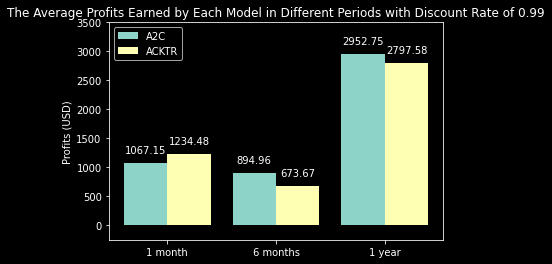

In [ ]:
# Plot the results
labels = ['1 month', '6 months', '1 year']

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, a2c_mean_99, width, label='A2C')
rects2 = ax.bar(x + width/2, acktr_mean_99, width, label='ACKTR')
ax.set_ylabel('Profits (USD)')
ax.set_title('The Average Profits Earned by Each Model in Different Periods with Discount Rate of 0.99')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim((-250,3500))
ax.legend()

autolabel(rects1)
autolabel(rects2)

plt.show()

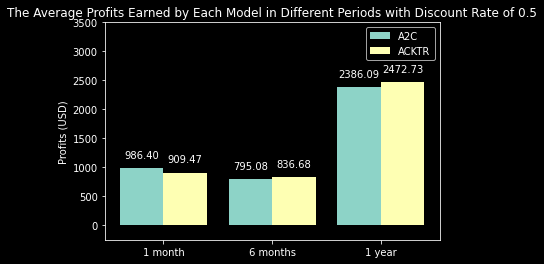

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, a2c_mean_05, width, label='A2C')
rects2 = ax.bar(x + width/2, acktr_mean_05, width, label='ACKTR')

ax.set_ylabel('Profits (USD)')
ax.set_title('The Average Profits Earned by Each Model in Different Periods with Discount Rate of 0.5')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim((-250,3500))
ax.legend()

autolabel(rects1)
autolabel(rects2)

plt.show()

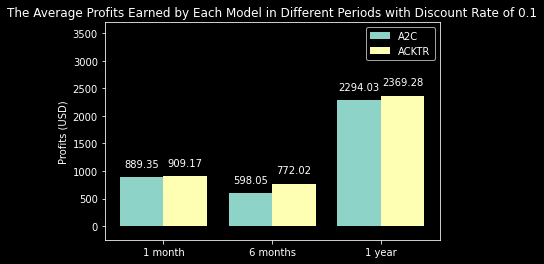

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, a2c_mean_01, width, label='A2C')
rects2 = ax.bar(x + width/2, acktr_mean_01, width, label='ACKTR')

ax.set_ylabel('Profits (USD)')
ax.set_title('The Average Profits Earned by Each Model in Different Periods with Discount Rate of 0.1')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim((-250,3700))
ax.legend()

autolabel(rects1)
autolabel(rects2)

plt.show()